In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class Vocab:
    def __init__(self, tokens, min_freq=1):
        counter = Counter(tokens)
        self.token_to_idx = {
            '<pad>': 0,
            '<sos>': 1,
            '<eos>': 2,
            '<unk>': 3
        }
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.token_to_idx:
                self.token_to_idx[token] = len(self.token_to_idx)
        self.idx_to_token = {idx: tok for tok, idx in self.token_to_idx.items()}

    def __len__(self):
        return len(self.token_to_idx)

    def encode(self, tokens):
        return [self.token_to_idx.get(tok, self.token_to_idx['<unk>']) for tok in tokens]

    def decode(self, indices):
        return [self.idx_to_token.get(idx, '<unk>') for idx in indices]


def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", r" ", sentence)
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return word_tokenize(sentence)


def load_dataset(file_path, num_samples=None):
    with open(file_path, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')

    if num_samples:
        lines = lines[:num_samples]

    input_sentences = []
    target_sentences = []

    for line in lines:
        en, es = line.split('\t')
        en_tokens = ['<sos>'] + preprocess_sentence(en) + ['<eos>']
        es_tokens = ['<sos>'] + preprocess_sentence(es) + ['<eos>']
        input_sentences.append(en_tokens)
        target_sentences.append(es_tokens)

    return input_sentences, target_sentences


def build_dataset(file_path='spa.txt', num_samples=10000):
    inputs, targets = load_dataset(file_path, num_samples)

    input_vocab = Vocab([tok for sent in inputs for tok in sent])
    target_vocab = Vocab([tok for sent in targets for tok in sent])

    input_indices = [torch.tensor(input_vocab.encode(s)) for s in inputs]
    target_indices = [torch.tensor(target_vocab.encode(s)) for s in targets]

    input_padded = pad_sequence(input_indices, batch_first=True, padding_value=input_vocab.token_to_idx['<pad>'])
    target_padded = pad_sequence(target_indices, batch_first=True, padding_value=target_vocab.token_to_idx['<pad>'])

    # 80/10/10 split
    total = len(input_padded)
    train_end = int(0.8 * total)
    val_end = int(0.9 * total)

    inp_train = input_padded[:train_end]
    targ_train = target_padded[:train_end]

    inp_val = input_padded[train_end:val_end]
    targ_val = target_padded[train_end:val_end]

    inp_test = input_padded[val_end:]
    targ_test = target_padded[val_end:]

    return inp_train, inp_val, inp_test, targ_train, targ_val, targ_test, input_vocab, target_vocab



In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [batch, src_len, emb_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [batch, src_len, enc_hidden*2]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))  # [batch, dec_hidden]
        return outputs, hidden.unsqueeze(0)  # [1, batch, dec_hidden]


In [4]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]  # [batch, src_len, enc_hidden*2]
        decoder_hidden = decoder_hidden.permute(1, 0, 2)  # [batch, 1, dec_hidden]
        decoder_hidden = decoder_hidden.repeat(1, src_len, 1)  # [batch, src_len, dec_hidden]

        energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs), dim=2)))  # [batch, src_len, dec_hidden]
        attention = self.v(energy).squeeze(2)  # [batch, src_len]
        return F.softmax(attention, dim=1)


In [5]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hidden_dim * 2 + emb_dim, dec_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input, decoder_hidden, encoder_outputs):
        input = input.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input))  # [batch, 1, emb_dim]

        a = self.attention(decoder_hidden, encoder_outputs)  # [batch, src_len]
        a = a.unsqueeze(1)  # [batch, 1, src_len]
        context = torch.bmm(a, encoder_outputs)  # [batch, 1, enc_hidden*2]

        rnn_input = torch.cat((embedded, context), dim=2)  # [batch, 1, emb+enc_hidden*2]
        output, hidden = self.rnn(rnn_input, decoder_hidden)  # hidden: [1, batch, dec_hidden]

        pred = self.fc_out(torch.cat((output, context, embedded), dim=2).squeeze(1))  # [batch, output_dim]
        return pred, hidden, a.squeeze(1)  # return attention weights for visualization


In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs


In [7]:
def train(model, iterator, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate_loss(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)  # no teacher forcing
            output_dim = output.shape[-1]

            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [8]:
# Prepare data
inp_train, inp_val, inp_test, targ_train, targ_val, targ_test, input_vocab, target_vocab = build_dataset(
    file_path='/kaggle/input/seq2seqdata/spa.txt', num_samples=10000
)

# Create loaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(inp_train, targ_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(inp_val, targ_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(inp_test, targ_test), batch_size=1)

# Build model
INPUT_DIM = len(input_vocab)
OUTPUT_DIM = len(target_vocab)
ENC_HID_DIM = 256
DEC_HID_DIM = 256
EMB_DIM = 128

attn = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attn)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())
PAD_IDX = target_vocab.token_to_idx['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Train for a few epochs
for epoch in range(1,26):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate_loss(model, val_loader, criterion)
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1: Train Loss = 4.3997, Val Loss = 4.3805
Epoch 2: Train Loss = 3.2790, Val Loss = 4.0222
Epoch 3: Train Loss = 2.6649, Val Loss = 3.7073
Epoch 4: Train Loss = 2.1302, Val Loss = 3.5932
Epoch 5: Train Loss = 1.7860, Val Loss = 3.5715
Epoch 6: Train Loss = 1.5148, Val Loss = 3.6159
Epoch 7: Train Loss = 1.3425, Val Loss = 3.6057
Epoch 8: Train Loss = 1.2244, Val Loss = 3.6604
Epoch 9: Train Loss = 1.1168, Val Loss = 3.6499
Epoch 10: Train Loss = 1.0661, Val Loss = 3.7468
Epoch 11: Train Loss = 0.9918, Val Loss = 3.7766
Epoch 12: Train Loss = 0.9404, Val Loss = 3.7666
Epoch 13: Train Loss = 0.9015, Val Loss = 3.8168
Epoch 14: Train Loss = 0.8472, Val Loss = 3.8149
Epoch 15: Train Loss = 0.8449, Val Loss = 3.8712
Epoch 16: Train Loss = 0.7949, Val Loss = 3.8841
Epoch 17: Train Loss = 0.7644, Val Loss = 3.9373
Epoch 18: Train Loss = 0.7510, Val Loss = 3.9849
Epoch 19: Train Loss = 0.7246, Val Loss = 3.9796
Epoch 20: Train Loss = 0.7082, Val Loss = 3.9759
Epoch 21: Train Loss = 0.6987

In [9]:
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

smoothie = SmoothingFunction().method4

def evaluate_bleu(model, inputs, targets, input_vocab, target_vocab, n_samples=100):
    model.eval()
    total_score = 0

    for i in range(min(n_samples, len(inputs))):
        src = inputs[i]
        trg = target_vocab.decode(targets[i].tolist())
        src_sentence = " ".join(input_vocab.decode(src.tolist()))
        pred, _ = translate_sentence(src_sentence, model, input_vocab, target_vocab)
        pred = [tok for tok in pred if tok not in ['<sos>', '<eos>', '<pad>']]
        trg = [tok for tok in trg if tok not in ['<sos>', '<eos>', '<pad>']]
        score = sentence_bleu([trg], pred, smoothing_function=smoothie)
        total_score += score

    return total_score / n_samples


In [10]:
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

smoothie = SmoothingFunction().method4

from torch.nn.functional import softmax


def translate_sentence(sentence, model, input_vocab, target_vocab, max_len=50):
    model.eval()
    tokens = ['<sos>'] + preprocess_sentence(sentence) + ['<eos>']
    input_ids = torch.tensor([input_vocab.encode(tokens)], dtype=torch.long).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_ids)
        input_token = torch.tensor([target_vocab.token_to_idx['<sos>']], device=device)

        translated_tokens = []
        attentions = []

        for _ in range(max_len):
            output, hidden, attention = model.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            translated_tokens.append(top1)
            attentions.append(attention.cpu().numpy())
            if top1 == target_vocab.token_to_idx['<eos>']:
                break
            input_token = torch.tensor([top1], device=device)

    translated_text = target_vocab.decode(translated_tokens)
    return translated_text, attentions


In [11]:
bleu_score = evaluate_bleu(model, inp_test, targ_test, input_vocab, target_vocab, n_samples=len(inp_test))
print(f"Test BLEU Score: {bleu_score:.4f}")

Test BLEU Score: 0.0851


In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(sentence_tokens, translation_tokens, attention_weights):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    attention_weights = np.squeeze(np.array(attention_weights))  # Removes 1-dimensions
    attention_weights = attention_weights[:len(translation_tokens), :len(sentence_tokens)]

    cax = ax.matshow(attention_weights, cmap='viridis')

    ax.set_xticklabels([''] + sentence_tokens, rotation=45)
    ax.set_yticklabels([''] + translation_tokens)

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    plt.colorbar(cax)
    plt.show()


In [25]:
def show_test_attention(model, inp_test, targ_test, input_vocab, target_vocab, index=0):
    model.eval()
    src_tensor = inp_test[index]
    src_tokens = input_vocab.decode(src_tensor.tolist())
    src_tokens = [tok for tok in src_tokens if tok not in ['<pad>']]

    sentence = " ".join([tok for tok in src_tokens if tok not in ['<sos>', '<eos>']])
    pred_tokens, attn_weights = translate_sentence(sentence, model, input_vocab, target_vocab)

    clean_src = [tok for tok in src_tokens if tok not in ['<sos>', '<eos>']]
    clean_pred = [tok for tok in pred_tokens if tok not in ['<sos>', '<eos>', '<pad>']]

    print(f"\n Input Sentence: {' '.join(clean_src)}")
    print(f" Predicted Translation: {' '.join(clean_pred)}")

    visualize_attention(['<sos>'] + clean_src + ['<eos>'], clean_pred, attn_weights)



 Input Sentence: there s no rush .
 Predicted Translation: ah no es en m s .


/tmp/ipykernel_31/2415246686.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence_tokens, rotation=45)
/tmp/ipykernel_31/2415246686.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation_tokens)


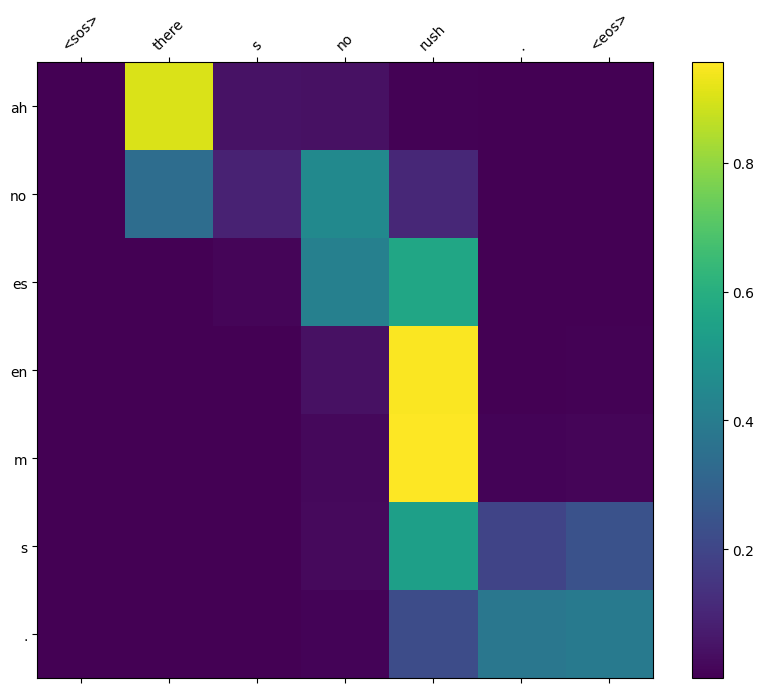


 Input Sentence: there s no salt .
 Predicted Translation: ah tienes en casa .


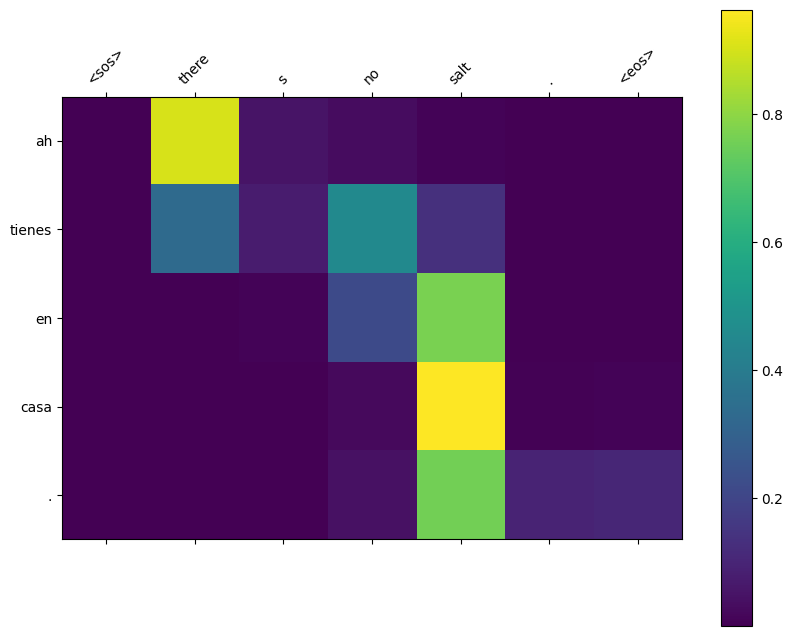


 Input Sentence: there s no time .
 Predicted Translation: ah hay en el momento .


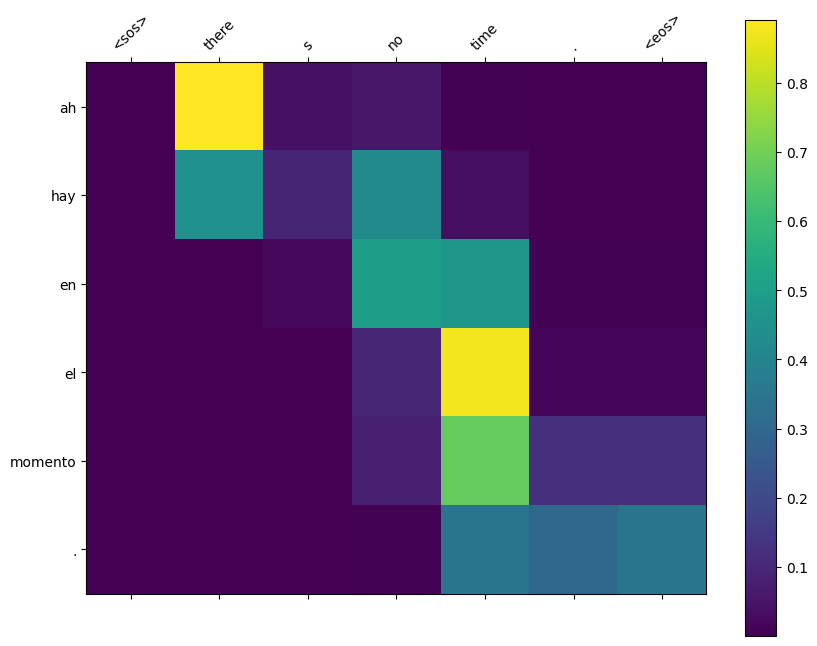

In [26]:
# sample_sentences = ["Hello.", "I am fine.", "How are you?", "Where is the bathroom?"]
for i in range(3):
    show_test_attention(model, inp_test, targ_test, input_vocab, target_vocab, index=i)